In [1]:
%load_ext autoreload
%autoreload 2
%load_ext notexbook

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm
import networkx as nx


from generate_incomplete_graph import *

plt.style.use("../config/custom_plt.mplstyle")

In [2]:
base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/"
texas_graph = nx.read_edgelist(f"{base_path}/out1_graph_edges.edge")

In [3]:
g, missing_links = generate_incomplete_network_gcc(texas_graph, q=0.8)
len(missing_links)

Before: 183 nodes. After: 34 nodes


236

In [4]:
import os

def experiment_generate_incomplete_networks(input_g, q_fractions, output_path, ntimes=5):
    for q in q_fractions:
        for i in range(ntimes):
            g, missing_links = generate_incomplete_network_gcc(input_g, q=q)
            
            str_q = str(q).replace('.', '_')
            os.makedirs(f"{output_path}/q_{str_q}/i{i}")
            nx.write_edgelist(g, f"{output_path}/q_{str_q}/i{i}/graph_{str_q}.edge", data=False)
            
            with open(f"{output_path}/q_{str_q}/i{i}/missing_links_{str_q}.txt", "w") as f:
                for m in missing_links:
                    f.write(f'{m[0]} {m[1]}\n')

In [5]:
output_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/incomplete_new/"
q_fractions = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# experiment_generate_incomplete_networks(texas_graph, q_fractions, output_path)


Before: 183 nodes. After: 177 nodes
Before: 183 nodes. After: 178 nodes
Before: 183 nodes. After: 181 nodes
Before: 183 nodes. After: 180 nodes
Before: 183 nodes. After: 181 nodes
Before: 183 nodes. After: 174 nodes
Before: 183 nodes. After: 173 nodes
Before: 183 nodes. After: 165 nodes
Before: 183 nodes. After: 176 nodes
Before: 183 nodes. After: 174 nodes
Before: 183 nodes. After: 157 nodes
Before: 183 nodes. After: 162 nodes
Before: 183 nodes. After: 162 nodes
Before: 183 nodes. After: 165 nodes
Before: 183 nodes. After: 164 nodes
Before: 183 nodes. After: 152 nodes
Before: 183 nodes. After: 150 nodes
Before: 183 nodes. After: 147 nodes
Before: 183 nodes. After: 149 nodes
Before: 183 nodes. After: 142 nodes
Before: 183 nodes. After: 135 nodes
Before: 183 nodes. After: 132 nodes
Before: 183 nodes. After: 129 nodes
Before: 183 nodes. After: 126 nodes
Before: 183 nodes. After: 131 nodes
Before: 183 nodes. After: 105 nodes
Before: 183 nodes. After: 120 nodes
Before: 183 nodes. After: 10

In [6]:
from numba import jit
from numba.typed import List, Dict
from numba.core import types
import numba
import math


def load_graph_and_coords_and_missing_links(graph_path, coords_path, missing_links_path):
    df = pd.read_csv(coords_path, comment="#", sep="\s+", header=None)
    df.columns = ['index', 'kappa', 'radius', 'p1', 'p2', 'p3']
    df['index'] = df['index'].astype(str)
    
    missing_links = []
    with open(missing_links_path, "r") as f:
        for line in f:
            missing_links.append(line.split())
            
    # Only evaluate the link prediction task on links inside GCC            
    missing_links_gcc = []
    for s, t in missing_links:
        if s in df['index'].values:
            if t in df['index'].values:
                missing_links_gcc.append((s, t))
    
    g = nx.read_edgelist(graph_path)
    return g, df, missing_links_gcc


def read_beta_and_mu_and_R(path):
    with open(path, 'r') as f:
        for line in f:
            if '- beta' in line:
                beta = float(line.split()[-1])
            elif '- mu' in line:
                mu = float(line.split()[-1])
            elif '- radius_S' in line:
                R = float(line.split()[-1])
        return beta, mu, R
    

@jit(nopython=True)
def fast_score(indices, pos, kappas, beta, mu, R):    
    scores = List()
    
    for i in range(len(pos)):
        for j in range(i):
            u, v = indices[i], indices[j]
            p1, p2 = pos[i], pos[j]
            k1, k2 = kappas[i], kappas[j]
            angle = np.arccos(np.dot(p1, p2) / (np.linalg.norm(p2) * np.linalg.norm(p1)))
            if np.isnan(angle):
                angle = 0
            
            prob = 1 / (1 + np.power((R * angle) / math.sqrt(mu * k1 * k2), beta))
            # Eq.2 from Dima's paper
            #prob = (1 - q) * prob / (1 - q * prob)
            scores.append((u, v, prob))
    return scores


def compute_score_matrix(g, df, beta, mu, R):
    nodes_order = list(g.nodes())
    df['index'] = df['index'].astype(str)
    df = df.set_index('index')
    df = df.loc[nodes_order]
    
    pos = df[['p1', 'p2', 'p3']].values
    kappas = df['kappa'].values
    
    df = df.reset_index()    
    indices = List(df['index'].values)
    score_list = fast_score(indices, pos, kappas, beta, mu, R)
    
    score_df = pd.DataFrame(score_list)
    score_df.columns = ['u', 'v', 'score']
    score_df = score_df.sort_values('score', ascending=False)
    return score_df


def compute_precision(score_df, missing_links_gcc):
    top_scores = score_df.head(len(missing_links_gcc))
    top_scores_set = set(top_scores[['u', 'v']].apply(np.sort, axis = 1).map(lambda x: f'{x[0]}-{x[1]}').values)
    
    missing_links_gcc_df = pd.DataFrame(missing_links_gcc)
    missing_links_gcc_df.columns = ['u', 'v']
    missing_links_set = set(missing_links_gcc_df.apply(np.sort, axis=1).map(lambda x: f'{x[0]}-{x[1]}').values)

    return len(top_scores_set & missing_links_set) / len(missing_links_gcc)


def get_precision(g_path, coords_path, missing_links_path):
    beta, mu, R = read_beta_and_mu_and_R(coords_path)
    g, coords, missing_links_gcc = load_graph_and_coords_and_missing_links(g_path, coords_path, missing_links_path)
    score = compute_score_matrix(g, coords, beta, mu, R)
    return compute_precision(score, missing_links_gcc)

In [8]:
%%time

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/incomplete_new"

le_ml_precisions = []
umap_ml_precisions = []
only_umap_precisions = []

gcc_sizes = []

for q in tqdm(q_fractions):
    str_q = str(q).replace('.', '_')
    
    tmp_le_ml_precisions = []
    tmp_umap_ml_precisions = []
    tmp_only_umap_precisions = []
    tmp_gcc_sizes = []
        
    for i in tqdm(range(5)):
        current_base_path = f"{base_path}/q_{str_q}/i{i}"
        g_path = f"{current_base_path}/graph_{str_q}.edge"
        missing_links_path = f"{current_base_path}/missing_links_{str_q}.txt"
        
        if not os.path.isfile(missing_links_path):
            continue
        
        tmp_gcc_sizes.append(nx.number_of_nodes(nx.read_edgelist(g_path)))
        
        # LE+ML
        coords_path = f"{current_base_path}/le_ml/graph_{str_q}.inf_coord"
        precision = get_precision(g_path, coords_path, missing_links_path)
        tmp_le_ml_precisions.append(precision)
        
        # UMAP+ML
        coords_path = f"{current_base_path}/umap_ml/graph_{str_q}.inf_coord"
        precision = get_precision(g_path, coords_path, missing_links_path)
        tmp_umap_ml_precisions.append(precision)
        
        # UMAP
        coords_path = f"{current_base_path}/only_umap/graph_{str_q}.inf_coord"
        precision = get_precision(g_path, coords_path, missing_links_path)
        tmp_only_umap_precisions.append(precision)
    
    le_ml_precisions.append(tmp_le_ml_precisions)
    umap_ml_precisions.append(tmp_umap_ml_precisions)
    only_umap_precisions.append(tmp_only_umap_precisions)
    
    gcc_sizes.append(tmp_gcc_sizes)

100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

CPU times: user 2.98 s, sys: 16.3 ms, total: 3 s
Wall time: 2.99 s


Text(0, 0.5, 'Precision')

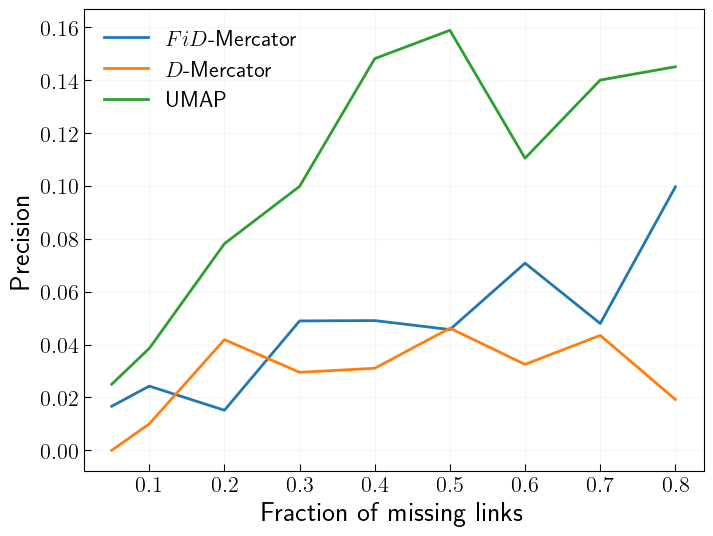

In [9]:
plt.plot(q_fractions, [np.mean(x) for x in umap_ml_precisions], label=r'$FiD$-Mercator')
plt.plot(q_fractions, [np.mean(x) for x in le_ml_precisions], label=r'$D$-Mercator')
plt.plot(q_fractions, [np.mean(x) for x in only_umap_precisions], label='UMAP')

plt.legend()
plt.xlabel('Fraction of missing links')
plt.ylabel('Precision')

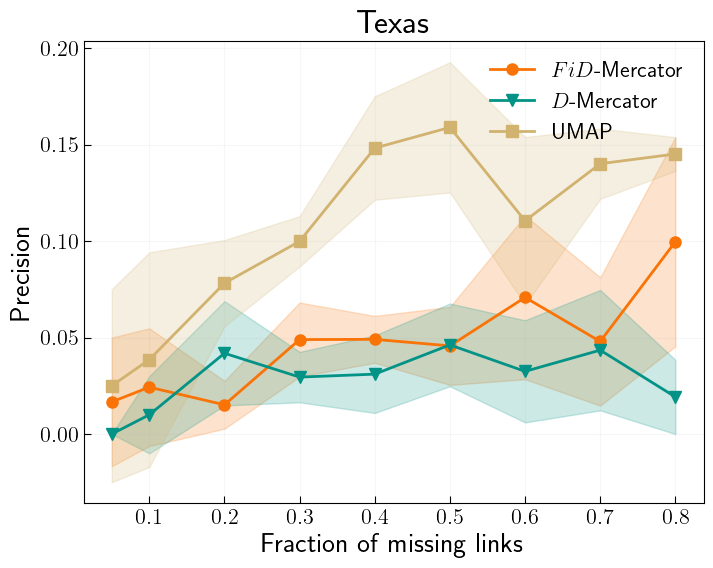

In [13]:
plt.plot(q_fractions, [np.mean(x) for x in umap_ml_precisions], 'o-', 
         color='xkcd:orange', label=r'$FiD$-Mercator')
plt.plot(q_fractions, [np.mean(x) for x in le_ml_precisions], 'v-', 
         color='xkcd:teal', label=r'$D$-Mercator')
plt.plot(q_fractions, [np.mean(x) for x in only_umap_precisions], 's-', 
         color='xkcd:tan', label='UMAP')

y = np.array([np.mean(x) for x in umap_ml_precisions])
y_std = np.array([np.std(x) for x in umap_ml_precisions])
plt.fill_between(q_fractions, y+y_std, y-y_std, color='xkcd:orange', alpha=0.2)

y = np.array([np.mean(x) for x in le_ml_precisions])
y_std = np.array([np.std(x) for x in le_ml_precisions])
plt.fill_between(q_fractions, y+y_std, y-y_std, color='xkcd:teal', alpha=0.2)

y = np.array([np.mean(x) for x in only_umap_precisions])
y_std = np.array([np.std(x) for x in only_umap_precisions])
plt.fill_between(q_fractions, y+y_std, y-y_std, color='xkcd:tan', alpha=0.2)

plt.legend()
plt.xlabel('Fraction of missing links')
plt.ylabel('Precision')
plt.title('Texas')

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/link-prediction-incomplete-networks-27-12-23/plots/lp_texas.pdf")


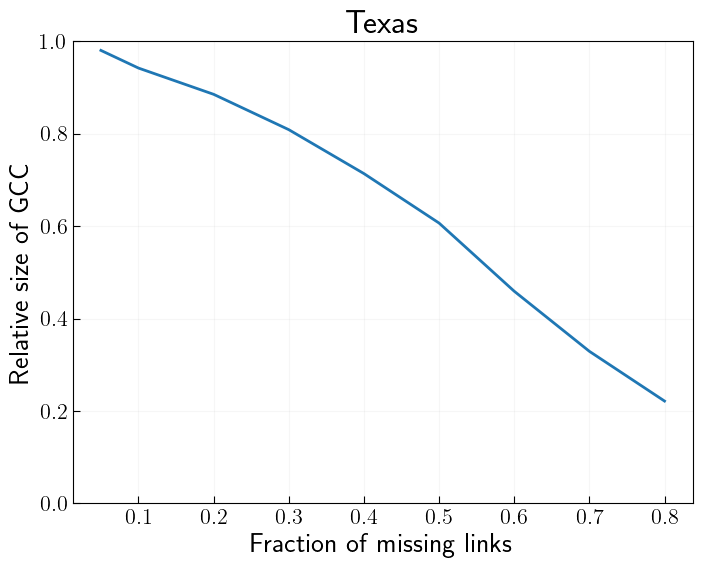

In [14]:
plt.plot(q_fractions, [np.mean(x) / nx.number_of_nodes(texas_graph) for x in gcc_sizes])
plt.xlabel('Fraction of missing links')
plt.ylabel('Relative size of GCC')
plt.ylim(0, 1)
plt.title('Texas')

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/link-prediction-incomplete-networks-27-12-23/plots/gcc_texas.pdf")
